### Environment Setup

In [ ]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    repo_dir = Path("mlfs-book")
    if repo_dir.exists():
        print(f"Repository already exists at {repo_dir.absolute()}")
        %cd mlfs-book
    else:
        print("Cloning repository...")
        !git clone https://github.com/featurestorebook/mlfs-book.git
        %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('titanic',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")

Local environment
Added the following directory to the PYTHONPATH: c:\Users\krist\Documents\GitHub\mlfs-book


In [3]:
import os
import hopsworks
import pandas as pd
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

project = hopsworks.login()
fs = project.get_feature_store()

HopsworksSettings initialized!
2025-12-10 11:27:18,949 INFO: Initializing external client
2025-12-10 11:27:18,950 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-12-10 11:27:19,661 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-12-10 11:27:21,918 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279184


### Load Data

In [8]:
titanic_df = pd.read_csv(f"{root_dir}/data/titanic.csv")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Feature Engineering

 * Impute any missing values for `Age` and `Embarked`

In [5]:
titanic_df = titanic_df[['PassengerId', 'Sex','Age','Pclass','Fare','Parch','SibSp','Embarked', 'Survived']]
#fill NAs with some imputed values
def_values = {'Age': titanic_df['Age'].mean(), 'Embarked': titanic_df['Embarked'].value_counts().idxmax()}
titanic_df = titanic_df.fillna(value=def_values)
titanic_df

,PassengerId,Sex,Age,Pclass,Fare,Parch,SibSp,Embarked,Survived
0,1,male,22.000000,3,7.2500,0,1,S,0
1,2,female,38.000000,1,71.2833,0,1,C,1
2,3,female,26.000000,3,7.9250,0,0,S,1
3,4,female,35.000000,1,53.1000,0,1,S,1
4,5,male,35.000000,3,8.0500,0,0,S,0
...,...,...,...,...,...,...,...,...,...
886,887,male,27.000000,2,13.0000,0,0,S,0
887,888,female,19.000000,1,30.0000,0,0,S,1
888,889,female,29.699118,3,23.4500,2,1,S,0
889,890,male,26.000000,1,30.0000,0,0,C,1


### Hopsworks

Create feature group in Hopsworks feature store

In [6]:
titanic_fg = fs.get_or_create_feature_group(
    name="titanic",
    version=1,
    primary_key=['PassengerId'],
    description="Titanic passengers dataset"
)

Insert data

In [7]:
titanic_fg.insert(titanic_df, wait=True)

2025-12-10 11:27:23,457 WARNING: FeatureGroupWarning: The ingested dataframe contains upper case letters in feature names: `['PassengerId', 'Sex', 'Age', 'Pclass', 'Fare', 'Parch', 'SibSp', 'Embarked', 'Survived']`. Feature names are sanitized to lower case in the feature store.



Uploading Dataframe: 100.00% |██████████| Rows 891/891 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: titanic_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279184/jobs/named/titanic_1_offline_fg_materialization/executions
2025-12-10 11:27:39,928 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-12-10 11:27:43,092 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-12-10 11:29:37,208 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-12-10 11:29:37,366 INFO: Waiting for log aggregation to finish.
2025-12-10 11:29:59,247 INFO: Execution finished successfully.


(Job('titanic_1_offline_fg_materialization', 'SPARK'), None)

### Exploration

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

Demographic vs Survival

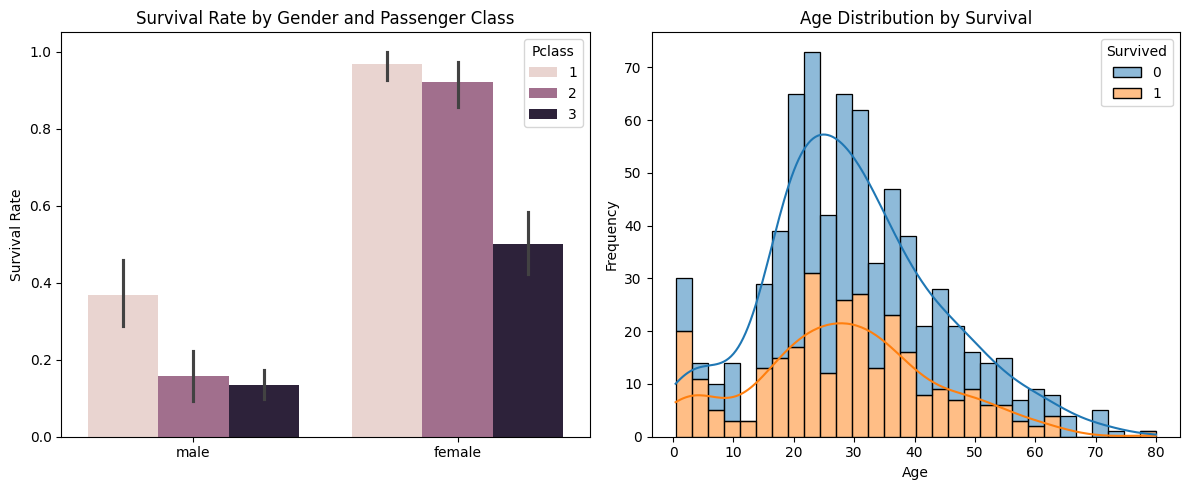

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Survival rate by gender and passenger class
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=titanic_df, ax=axes[0])
axes[0].set_title('Survival Rate by Gender and Passenger Class')
axes[0].set_xlabel('')
axes[0].set_ylabel('Survival Rate')

# Age distribution by survival
sns.histplot(data=titanic_df, x='Age', hue='Survived', multiple='stack', bins=30, kde=True, ax=axes[1])
axes[1].set_title('Age Distribution by Survival')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

Socioeconomic Signals

2025-12-10 13:56:29,288 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-10 13:56:29,294 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-10 13:56:29,315 WARNING: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

2025-12-10 13:56:29,353 WARNING: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



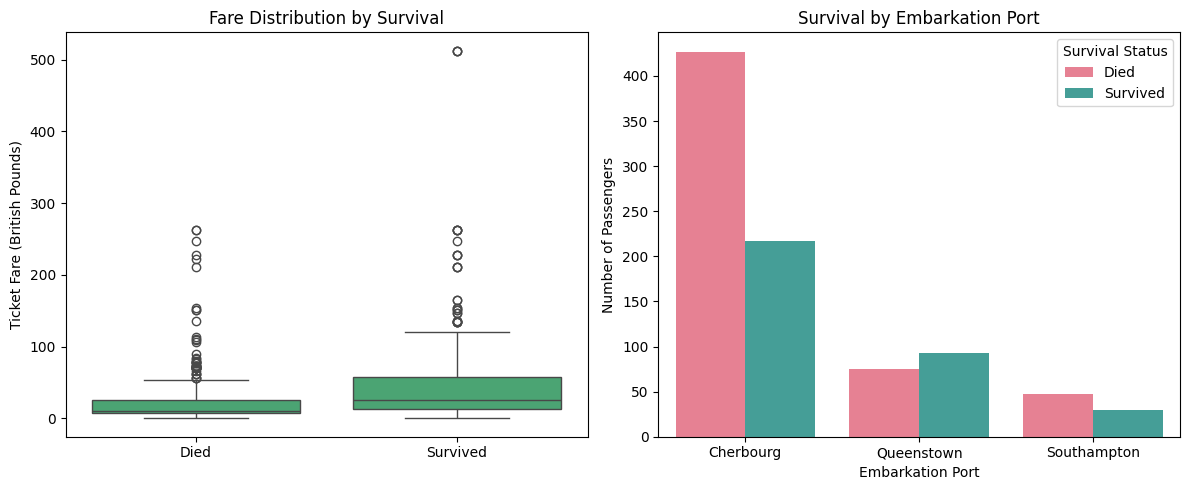

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Fare vs. survival
sns.boxplot(x="Survived", y="Fare", data=titanic_df, ax=axes[0], color="mediumseagreen")
axes[0].set_title("Fare Distribution by Survival")
axes[0].set_xlabel("")
axes[0].set_ylabel("Ticket Fare (British Pounds)")
axes[0].set_xticklabels(['Died', 'Survived'])

# Embarkation port vs. survival
sns.countplot(x='Embarked', hue="Survived", data=titanic_df, ax=axes[1], palette="husl")
axes[1].set_title("Survival by Embarkation Port")
axes[1].set_xlabel("Embarkation Port")
axes[1].set_ylabel("Number of Passengers")
axes[1].legend(title="Survival Status", labels=['Died', 'Survived'])
axes[1].set_xticklabels(['Cherbourg', 'Queenstown', 'Southampton'])

plt.tight_layout()
plt.show()

Family Structure & Group Travel

2025-12-10 13:54:11,389 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-10 13:54:11,392 WARNING: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


2025-12-10 13:54:11,399 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-10 13:54:11,567 WARNING: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


2025-12-10 13:54:11,638 WARNING: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after se

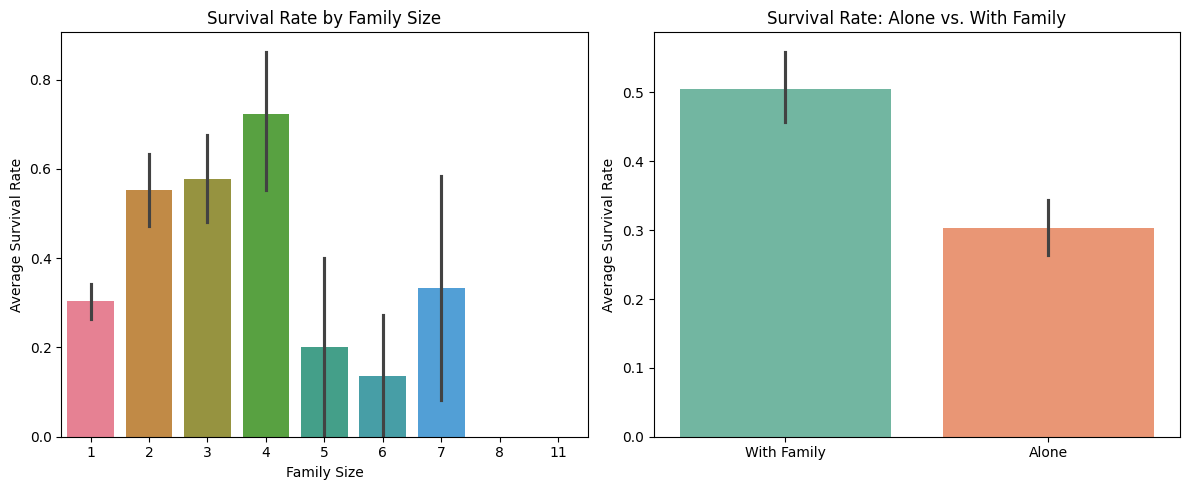

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Survival rate by family size
sns.barplot(x=(titanic_df["SibSp"] + titanic_df["Parch"] + 1), y="Survived", data=titanic_df, 
            ax=axes[0], palette="husl")

axes[0].set_title("Survival Rate by Family Size")
axes[0].set_xlabel("Family Size")
axes[0].set_ylabel("Average Survival Rate")

# Solo vs. group travelers
titanic_df["IsAlone"] = titanic_df["FamilySize"] == 1
sns.barplot(x="IsAlone", y="Survived", data=titanic_df, ax=axes[1], palette="Set2")
axes[1].set_title("Survival Rate: Alone vs. With Family")
axes[1].set_xlabel("")
axes[1].set_ylabel("Average Survival Rate")
axes[1].set_xticklabels(['With Family', 'Alone'])

plt.tight_layout()
plt.show()